In [ ]:
url = 'https://drive.google.com/file/d/16O04PRpsQrjcc6g_5skcLwOOeayv_xUr/edit'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
data = pd.read_csv(path)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import catboost
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score


Предсказание числа цитирований является задачей регрессии, поэтому будут использоваться алгоритмы, которые лучшим образом справляются именно с этим типом задач. 
Однако для начала необходимо познакомиться с данными и провести предобработку.

# Exploratory Data Analysis

In [4]:
# Посмотрим на 10 случайных строк. Видим, что как минимум в трех столбцах встречаются пропущенные значения

data.sample(10)

,recency,topic_rank,diversity,authors_mean_rank,authors_mean_hindex,authors_mean_gindex,authors_mean_sociality,authors_mean_pagerank,authors_mean_productivity,journal_pagerank,journal_rank,title_len,abstract_len,n_authors,c5,log_authors_mean_sociality
69,15,18.0,-0.116174,934.0,1.0,1.0,9.0,NaN,NaN,NaN,204.0,72,1721,10,2.0,2.302585
97,5,12.0,-0.974201,1935.0,1.0,1.0,5.0,NaN,NaN,NaN,NaN,64,341,6,2.0,1.791759
132,8,4.0,-1.201103,1662.0,1.0,1.0,5.0,NaN,NaN,NaN,326.0,128,1188,6,1.0,1.791759
120,25,6.0,-1.701851,315.0,1.0,1.0,3.0,NaN,NaN,NaN,75.0,110,0,4,1.0,1.386294
141,17,7.0,-0.142626,599.0,1.0,1.0,0.0,NaN,NaN,NaN,127.0,82,1586,1,0.0,0.000000
349,17,15.0,-0.204586,797.0,1.0,1.0,4.0,NaN,NaN,NaN,176.0,102,1109,5,0.0,1.609438
335,14,7.0,-1.559694,1086.0,1.0,1.0,4.0,NaN,NaN,NaN,243.0,70,0,5,1.0,1.609438
367,17,17.0,-0.283168,57.0,1.0,1.0,5.0,NaN,NaN,NaN,14.0,110,745,6,11.0,1.791759
127,12,16.0,-0.499816,523.0,1.0,1.0,0.0,NaN,NaN,NaN,133.0,91,436,1,13.0,0.000000
134,21,2.0,-0.400070,145.0,1.0,1.0,3.0,NaN,NaN,NaN,32.0,101,562,4,1.0,1.386294


In [5]:
data.shape

(479, 16)

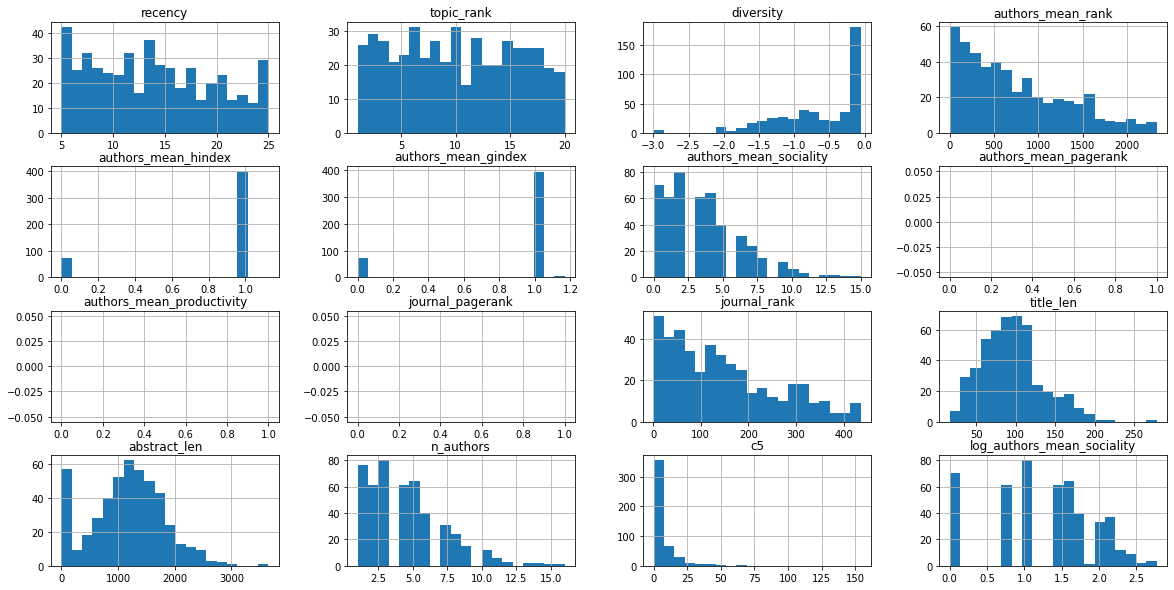

In [6]:
data.hist(bins =20,figsize = (20,10));

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479 entries, 0 to 478
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   recency                     479 non-null    int64  
 1   topic_rank                  479 non-null    float64
 2   diversity                   479 non-null    float64
 3   authors_mean_rank           473 non-null    float64
 4   authors_mean_hindex         473 non-null    float64
 5   authors_mean_gindex         473 non-null    float64
 6   authors_mean_sociality      473 non-null    float64
 7   authors_mean_pagerank       0 non-null      float64
 8   authors_mean_productivity   0 non-null      float64
 9   journal_pagerank            0 non-null      float64
 10  journal_rank                440 non-null    float64
 11  title_len                   479 non-null    int64  
 12  abstract_len                479 non-null    int64  
 13  n_authors                   479 non

Число цитирований - натуральное число, поэтому приведем его к этому виду

In [8]:
data['c5'] = data['c5'].astype(int)

In [9]:
data.describe()

,recency,topic_rank,diversity,authors_mean_rank,authors_mean_hindex,authors_mean_gindex,authors_mean_sociality,authors_mean_pagerank,authors_mean_productivity,journal_pagerank,journal_rank,title_len,abstract_len,n_authors,c5,log_authors_mean_sociality
count,479.000000,479.000000,479.000000,473.000000,473.000000,473.000000,473.000000,0.0,0.0,0.0,440.000000,479.000000,479.000000,479.000000,479.000000,473.000000
mean,13.419624,10.125261,-0.675481,741.769615,0.844051,0.844668,3.411132,NaN,NaN,NaN,146.184091,94.983299,1162.283925,4.369520,6.713987,1.264066
std,5.860415,5.748655,0.606013,581.948922,0.363961,0.364351,2.790555,NaN,NaN,NaN,111.398299,38.524238,657.597003,2.800775,12.547968,0.703466
min,5.000000,1.000000,-2.995732,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,1.000000,16.000000,0.000000,1.000000,0.000000,0.000000
25%,8.000000,5.000000,-1.087146,265.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,53.750000,68.000000,758.500000,2.000000,0.000000,0.693147
50%,13.000000,10.000000,-0.526332,596.000000,1.000000,1.000000,3.000000,NaN,NaN,NaN,122.000000,91.000000,1197.000000,4.000000,2.000000,1.386294
75%,18.000000,15.000000,-0.150066,1141.000000,1.000000,1.000000,5.000000,NaN,NaN,NaN,216.750000,116.500000,1587.500000,6.000000,8.000000,1.791759
max,25.000000,20.000000,-0.056685,2336.000000,1.125000,1.166667,15.000000,NaN,NaN,NaN,436.000000,279.000000,3655.000000,16.000000,154.000000,2.772589


Видим, что три колонки не содержат никакой информации. Удаляем их

In [10]:
data.drop(columns=['authors_mean_pagerank',	'authors_mean_productivity',	'journal_pagerank'], inplace=True)

Посмотрим на корреляции в данных. Видим, что у нас есть линейно зависимые признаки:

authors_mean_rank - journal rank

authors_mean_hindex - authors_mean_gindex

authors_mean_sociality - log_authors_mean_sociality - n authors

Это может приводить к вырожденности матрицы и как следствие плохому качеству предсказания. Поэтому удалим дублирующие данные

In [11]:
data.corr().style.background_gradient(cmap='YlOrRd')                   

,recency,topic_rank,diversity,authors_mean_rank,authors_mean_hindex,authors_mean_gindex,authors_mean_sociality,journal_rank,title_len,abstract_len,n_authors,c5,log_authors_mean_sociality
recency,1.000000,0.006633,0.134188,-0.605363,-0.053975,-0.056349,-0.207384,-0.501698,-0.098795,-0.184433,-0.211105,-0.205645,-0.196026
topic_rank,0.006633,1.000000,0.007051,0.043518,-0.107014,-0.107936,-0.042892,0.076514,-0.121407,-0.092573,-0.049917,-0.010784,-0.042618
diversity,0.134188,0.007051,1.000000,-0.280521,0.316729,0.316303,0.132571,-0.345223,0.217731,0.451929,0.144574,0.066988,0.178806
authors_mean_rank,-0.605363,0.043518,-0.280521,1.000000,-0.429332,-0.425947,-0.038268,0.935828,-0.011043,-0.171054,-0.038564,-0.353788,-0.049710
authors_mean_hindex,-0.053975,-0.107014,0.316729,-0.429332,1.000000,0.999655,0.217602,-0.532220,0.226990,0.323994,0.217765,0.232115,0.273413
authors_mean_gindex,-0.056349,-0.107936,0.316303,-0.425947,0.999655,1.000000,0.218880,-0.528544,0.227339,0.322870,0.219017,0.231432,0.274711
authors_mean_sociality,-0.207384,-0.042892,0.132571,-0.038268,0.217602,0.218880,1.000000,-0.069038,0.370253,0.314133,0.999969,0.134659,0.928274
journal_rank,-0.501698,0.076514,-0.345223,0.935828,-0.532220,-0.528544,-0.069038,1.000000,-0.091349,-0.288544,-0.084330,-0.361605,-0.094467
title_len,-0.098795,-0.121407,0.217731,-0.011043,0.226990,0.227339,0.370253,-0.091349,1.000000,0.323468,0.378244,0.005062,0.400204
abstract_len,-0.184433,-0.092573,0.451929,-0.171054,0.323994,0.322870,0.314133,-0.288544,0.323468,1.000000,0.330167,0.209358,0.363277


In [12]:
data.drop(columns=['journal_rank', 'authors_mean_gindex', 'log_authors_mean_sociality','authors_mean_sociality'], inplace=True)

Посмотрим на гистаграмму распределения числа цитирований и подсчитаем, сколько у нас примеров на каждое значение c5.

Спойлер: основная часть приходится на с5 = 0. Большая часть индексов < 20.

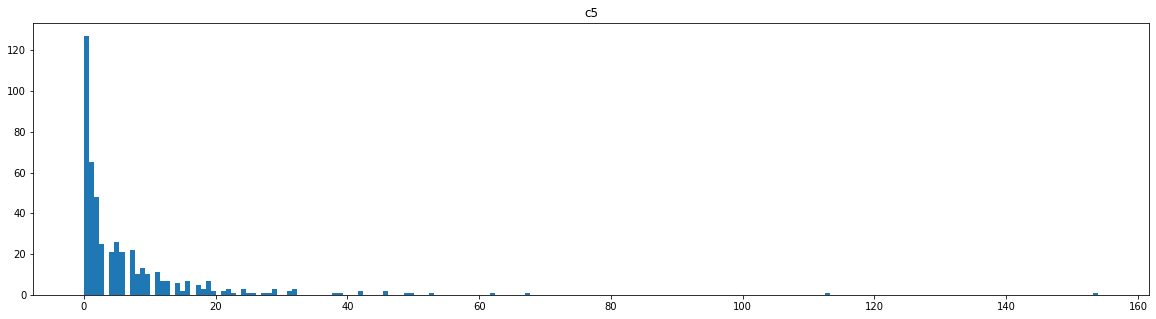

In [13]:
data.hist(column='c5', grid=False, figsize = (20,5), bins = 200);

In [14]:
counted = data['c5'].value_counts().reset_index()
counted.columns = ['c5', 'quantity']
counted.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42
c5,0,1,2,5,3,7,4,6,9,11,10,8,12,13,16,19,14,17,32,18,29,24,22,15,21,20,42,31,46,67,62,53,50,49,39,113,38,28,27,26,25,23,154
quantity,127,65,48,26,25,22,21,21,13,11,10,10,7,7,7,7,6,5,3,3,3,3,3,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [15]:
data.columns

Index(['recency', 'topic_rank', 'diversity', 'authors_mean_rank',
       'authors_mean_hindex', 'title_len', 'abstract_len', 'n_authors', 'c5'],
      dtype='object')

Проверим наличие пропущенных значений в оставшихся данных и удалим пропуски

In [16]:
data.isna().sum()

recency                0
topic_rank             0
diversity              0
authors_mean_rank      6
authors_mean_hindex    6
title_len              0
abstract_len           0
n_authors              0
c5                     0
dtype: int64

In [17]:
feature_names = ['recency', 'topic_rank', 'diversity', 'authors_mean_rank',
       'authors_mean_hindex', 'title_len', 'abstract_len', 'n_authors'] 
df = data.dropna()

In [18]:
df.isna().sum()

recency                0
topic_rank             0
diversity              0
authors_mean_rank      0
authors_mean_hindex    0
title_len              0
abstract_len           0
n_authors              0
c5                     0
dtype: int64

# Предсказания

Напишем функцию, которая будет производить кросс-валидацию по методу Монте-Карло:
n раз делить нашу выборку на тестовую и обучающую и вычислять r^2, а затем выдаст среднее от всех значений. На больших выборках данная кросс-валидация показывает лучшие результаты, в то время как обычная кросс-валидация может показывать завышенные значения. 

In [19]:
def Monte_Carlo_cv(data, y : str, model, n = 100, Scale = False, split_size = 0.3):
  '''
  data - данные, которые используем для расчетов
  y - название колонки с таргетными значениями
  model - модель регрессора
  n - число итераций
  Scale - нужно ли нормализовать данные или нет
  split_size - размер тестовой выборки
  
  '''
  r2 = 0
  i=0

  while i < n:
    X_train, X_test, y_train, y_test = train_test_split(data.loc[:, data.columns != y], data[y], test_size=0.33)
    if Scale == True:
      scaler = StandardScaler()
      X_train = scaler.fit_transform(X_train)
      X_test = scaler.transform(X_test)
      
    model.fit(X_train,y_train)
    y_pred  = model.predict(X_test).astype('int')
    r2 += r2_score(y_test, y_pred)
    i += 1
  return (r2/i).round(2)


## Начнем с обычной линейной регрессии



In [20]:
lr = LinearRegression()
r2 = Monte_Carlo_cv(df, 'c5', lr, 1000, Scale=True)
result = pd.DataFrame({'Model': 'Linear Regression', 'R2': [r2]})
r2

0.44

Как видно, обычная справляется плохо. Оценим важность признаков.

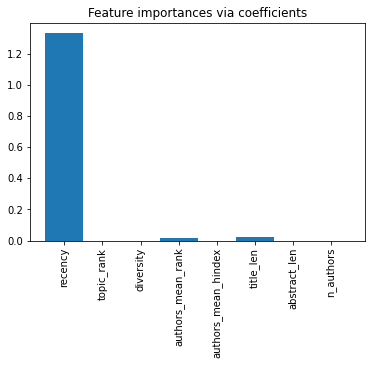

In [22]:
from sklearn.linear_model import LassoCV

lasso = LassoCV().fit(df[feature_names], df.c5)
importance = np.abs(lasso.coef_)
plt.bar(height=importance, x=feature_names, width = 1)
plt.title("Feature importances via coefficients")
plt.xticks(rotation='vertical')
plt.show()

In [23]:
selected_df = df[['recency', 'authors_mean_rank', 'authors_mean_hindex','c5']]
r2 = Monte_Carlo_cv(selected_df , 'c5', lr, 1000, Scale=False)
r2

0.46

Отбор признаков приводит к улучшению предсказаний. Несмотря на нулевой вес authors_mean_hindex, удалять его кажется нецелесообразным. 

Попробуем несколько более сложных алгоритмов. Пусть результаты записываются в таблицу, по которой можно будет оценить предсказания каждой модели и выбрать ту, что лучше справится с задачей.

## Более сложные алгоритмы

In [24]:
grad_boost = GradientBoostingRegressor()
rand_forest = RandomForestRegressor()
dec_tree = DecisionTreeRegressor(max_depth=6)
ada_boost = AdaBoostRegressor(DecisionTreeRegressor(max_depth=6),n_estimators=100)
xgbr = xgb.XGBRegressor(verbosity=0)

models = {grad_boost: 'Gradient Boosting', rand_forest:' Random Forest', dec_tree: 'Decision Tree', ada_boost: 'Ada Boost', xgbr:'XGB Regressor'}

In [25]:
for key,value in models.items():
  r2 = Monte_Carlo_cv(df, 'c5', key, 1000, Scale=True)
  result = result.append([{'Model' : value, 'R2': r2}], ignore_index=True)

In [26]:
for key,value in models.items():
  r2 = Monte_Carlo_cv(selected_df, 'c5', key, 1000, Scale=True)
  result = result.append([{'Model' : value + ' with selected features', 'R2': r2}], ignore_index=True)

In [28]:
result

,Model,R2
0,Linear Regression,0.44
1,Gradient Boosting,0.65
2,Random Forest,0.56
3,Decision Tree,0.22
4,Ada Boost,0.55
5,XGB Regressor,0.70
6,Gradient Boosting with selected features,0.76
7,Random Forest with selected features,0.72
8,Decision Tree with selected features,0.56
9,Ada Boost with selected features,0.63


Попробуем подобрать параметры для CatBoost Regressor с помощью Grid Search

In [29]:
grid = {'learning_rate': [0.001, 0.01, 0.1, 1],
        'depth': [2, 4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}
cat = CatBoostRegressor()
grid_search_result = cat.grid_search(grid, X=selected_df.loc[:, selected_df.columns != 'c5'], y=selected_df.c5, plot=False, cv = 3)
grid_search_result['params']


bestTest = 9.419996636
bestIteration = 999

0:	loss: 9.4199966	best: 9.4199966 (0)	total: 257ms	remaining: 20.3s

bestTest = 4.448391598
bestIteration = 999

1:	loss: 4.4483916	best: 4.4483916 (1)	total: 464ms	remaining: 18.1s

bestTest = 3.560753509
bestIteration = 243

2:	loss: 3.5607535	best: 3.5607535 (2)	total: 669ms	remaining: 17.2s

bestTest = 3.574073262
bestIteration = 18

3:	loss: 3.5740733	best: 3.5607535 (2)	total: 892ms	remaining: 16.9s

bestTest = 9.697045732
bestIteration = 999

4:	loss: 9.6970457	best: 3.5607535 (2)	total: 1.08s	remaining: 16.3s

bestTest = 4.733520191
bestIteration = 973

5:	loss: 4.7335202	best: 3.5607535 (2)	total: 1.28s	remaining: 15.8s

bestTest = 3.597030128
bestIteration = 967

6:	loss: 3.5970301	best: 3.5607535 (2)	total: 1.49s	remaining: 15.6s

bestTest = 3.660920928
bestIteration = 42

7:	loss: 3.6609209	best: 3.5607535 (2)	total: 1.7s	remaining: 15.3s

bestTest = 9.827832573
bestIteration = 999

8:	loss: 9.8278326	best: 3.5607535 (2)	total: 

{'depth': 4, 'l2_leaf_reg': 3, 'learning_rate': 0.1}

Подставим лучшие параметры и посчитаем точность предсказаний

In [30]:
cat = CatBoostRegressor(depth = 4, l2_leaf_reg = 3, learning_rate = 0.1)
r2 = Monte_Carlo_cv(df, 'c5', key, 1000, Scale=True)
result = result.append([{'Model' : 'CatBoost Regressor', 'R2': r2}], ignore_index=True)

r2 = Monte_Carlo_cv(selected_df, 'c5', key, 1000, Scale=True)
result = result.append([{'Model' : 'CatBoost Regressor with selected features', 'R2': r2}], ignore_index=True)

In [31]:
result.sort_values(by='R2', ascending=False)

,Model,R2
6,Gradient Boosting with selected features,0.76
10,XGB Regressor with selected features,0.76
12,CatBoost Regressor with selected features,0.76
7,Random Forest with selected features,0.72
5,XGB Regressor,0.70
11,CatBoost Regressor,0.70
1,Gradient Boosting,0.65
9,Ada Boost with selected features,0.63
2,Random Forest,0.56
8,Decision Tree with selected features,0.56
